<a href="https://colab.research.google.com/github/ganeshbmc/GenAI_Math/blob/main/GAN_Vanilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Steps  
1. Import libraries  
2. Prepare data  
   ```Download  |  Transform  |  Dataloader```  
3. Define parameters  
   ```Model  |  Optimizer  |  Loss  |  Training  ```
4. Build Model  
   ```Components  ```
5. Training loop  
6. Visualize results  

## Import libraries  

In [29]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import datetime

print(f"Imports completed at {datetime.datetime.now()}")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Versions
print(f"Torch: {torch.__version__}, TorchVision: {torchvision.__version__}")

Imports completed at 2025-08-20 08:21:04.991588
Using device: cuda
Torch: 2.8.0+cu126, TorchVision: 0.23.0+cu126


## Define parameters  

In [30]:
# Set seed for PyTorch
seed = 42
torch.manual_seed(seed)

# Data prep params
batch_size = 128

# Model params
noise_dim = 100     # z_dim
img_dim = 28 * 28 # MNIST size

# Optimizer params
learning_rate = 0.0002

# # Loss params
# criterion = nn.BCELoss()

# Training params
num_epochs = 20
generator_rounds = 1
discriminator_rounds = 1

## Prepare data  

In [31]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
print(f"Transform to be applied:\n{transform}\n")

# Load MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(f"Train data:\n{train_dataset}\n")

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Data loader:\n{train_loader}")

Transform to be applied:
Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

Train data:
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

Data loader:


## Build Model  
```Vanilla GAN```  
- MLP as neural network  

Generator
- noise_dim -> hidden layers -> img_dim with ReLU and Tanh  

Discriminator
- img_dim -> hidden layers -> 1 with Sigmoid activation  

In [32]:
# Generator
class Generator(nn.Module):
  def __init__(self, noise_dim, img_dim):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        # MLP
        nn.Linear(noise_dim, 256),
        nn.ReLU(True),
        nn.Linear(256, 512),
        nn.ReLU(True),
        nn.Linear(512, 1024),
        nn.ReLU(True),
        nn.Linear(1024, img_dim),
        nn.Tanh()   # Because we normalized images to [-1, 1]
    )

  def forward(self, z):
    return self.model(z)

In [33]:
generator = Generator(noise_dim=noise_dim, img_dim=img_dim).to(device)
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [34]:
# Discriminator
class Discriminator(nn.Module):
  def __init__(self, img_dim):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(img_dim, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 1),
        nn.Sigmoid()    # Outputs probability between 0 and 1
    )

  def forward(self, img):
    o = self.model(img)
    return o

In [35]:
discriminator = Discriminator(img_dim).to(device)
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

## Set up Optimizers  

In [36]:
g_optim = optim.Adam(generator.parameters(), lr=learning_rate)
g_optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

In [37]:
d_optim = optim.Adam(discriminator.parameters(), lr=learning_rate)
d_optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

## Set up Loss functions  

In [38]:
criterion = nn.BCELoss()
criterion

BCELoss()

## Code for visualizations  

In [39]:
def show_generated_images(epoch, generator, fixed_noise):
    generator.eval()
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).reshape(-1, 1, 28, 28)
        fake_imgs = fake_imgs * 0.5 + 0.5  # De-normalize

    grid = torchvision.utils.make_grid(fake_imgs, nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f'Generated Images at Epoch {epoch}')
    plt.axis('off')
    plt.show()
    generator.train()

## Training loop  
- Visualize results every 10 epochs  

In [40]:
def gan_trainer(train_loader, num_epochs=20, discriminator_rounds=1, generator_rounds=1):
  fixed_noise = torch.randn(64, noise_dim).to(device)  # For consistent visualization

  # Training loop
  for epoch in range(num_epochs):
    for batch_idx, (real, label) in enumerate(train_loader):  # We will not be using MNIST class label for GAN training
      batch_size = real.size(0)
      real = real.view(batch_size, -1).to(device)

      ## Create real and fake labels (note that these are not MNIST class labels. Just labels which tell if image is fake or real)
      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)

      ### ====================================
      ### 1. Train Discriminator
      ### ====================================
      for _ in range(discriminator_rounds):
        # Real images and loss
        outputs = discriminator(real)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Fake images and loss
        z = torch.randn(batch_size, noise_dim).to(device)
        fake = generator(z)
        outputs = discriminator(fake.detach())    # Detach so gradients don't flow into generator
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake

        # Update Discriminator params
        discriminator.zero_grad()
        d_loss.backward()
        d_optim.step()

      ### ====================================
      ### 2. Train Generator
      ### ====================================
      for _ in range(generator_rounds):
        # Generate fake images again
        z = torch.randn(batch_size, noise_dim).to(device)
        fake = generator(z)
        outputs = discriminator(fake)

        g_loss = criterion(outputs, real_labels)  # trick discriminator

        # Update Generator params
        generator.zero_grad()
        g_loss.backward()
        g_optim.step()


    # Visualize
    if (epoch+1) % 10 == 0:
      print(f"Epoch: [{epoch+1}/{num_epochs}]")
      print(f"Size of real images: {real.size()}")
      print(f"Discriminator loss = {d_loss.item():.4f}")
      print(f"Generator loss = {g_loss.item():.4f}")
      show_generated_images(epoch=epoch+1, generator=generator, fixed_noise=fixed_noise)

## Training  

Epoch: [10/20]
Size of real images: torch.Size([96, 784])
Discriminator loss = 0.6463
Generator loss = 1.9740


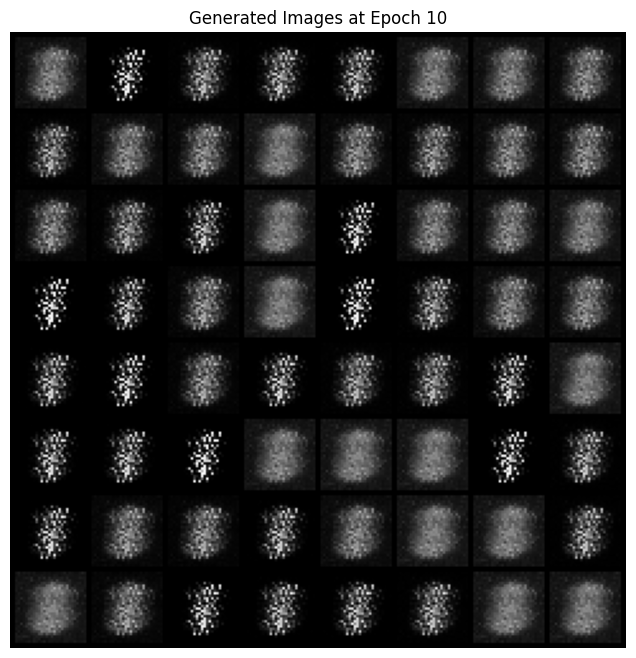

Epoch: [20/20]
Size of real images: torch.Size([96, 784])
Discriminator loss = 0.4225
Generator loss = 10.3852


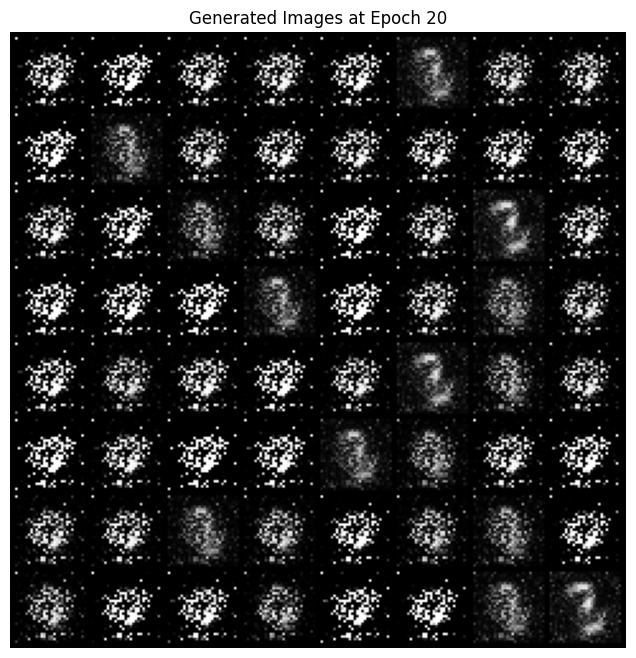

In [41]:
gan_trainer(train_loader,
            num_epochs=num_epochs,
            discriminator_rounds=discriminator_rounds,
            generator_rounds=generator_rounds
            )